In [1]:
## Load modules
import warnings; warnings.filterwarnings('ignore') # Suppress all warnings
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import os
from scipy import stats
from scipy.stats import pearsonr
import cmaps
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import xesmf as xe

from scipy import stats
def linregress_1d(x, y):
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

def linregress_xr(da, dim="time"):
    NT = len(da[dim])
    da[dim] = np.arange(0, NT)
    stats = xr.apply_ufunc(
        linregress_1d,
        da[dim],
        da,
        input_core_dims=[[dim], [dim]],
        output_core_dims=[["parameter"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["float32"],
        output_sizes={"parameter": 5},
    )
    return (NT - 1) * stats[:, :, 0], stats[:, :, 3]

## Load CESM2 and CESM2-FA

In [2]:
ds_cntl   = xr.open_mfdataset("../data/TS_hist_ssp585_1950-2049_cesm2_*.nc", combine="nested", concat_dim="member")
ds_fa     = xr.open_mfdataset("../data/TS_hist_ssp585_1950-2049_cesm2fa_*.nc", combine="nested", concat_dim="member")

In [3]:
# For regridding:
target_grid = xr.Dataset({'lat': (['lat'], np.arange(-30.5, 31, 1)),
        'lon': (['lon'], np.arange(100.5,291,1)),})

In [4]:
# Start and end year of trend analysis:
y0 = 1970
ye = 2020

In [5]:
## Get trend: CESM2
VAR = 'TS'
lst_t= []
lst_p = []
for i in range(15): 
    ds = ds_cntl.isel(member = i)
    ds = ds.sel(time=slice(str(y0), str(ye))).resample(time='1Y').mean()
    ds = ds.compute()
    # Regried
    regridder=xe.Regridder(ds[VAR], target_grid, 'bilinear')
    ds_rg = regridder(ds)
    # Calulate trend
    t, p = linregress_xr(ds_rg[VAR])
    lst_t.append(t.values) 
    lst_p.append(p.values)

ds_trend_cntl = xr.Dataset()
ds_trend_cntl['trend'] = (('member','lat','lon'), np.array(lst_t))
ds_trend_cntl['pvalue']  = (('member','lat','lon'), np.array(lst_p))
ds_trend_cntl.coords['lat'] = target_grid.lat
ds_trend_cntl.coords['lon'] = target_grid.lon

In [6]:
## Get trend: CESM2-FA
lst_t= []
lst_p = []
for i in range(15): 
    ds = ds_fa.isel(member = i)
    ds = ds.sel(time=slice(str(y0), str(ye))).resample(time='1Y').mean()
    ds = ds.compute()
    # Regried
    regridder=xe.Regridder(ds[VAR], target_grid, 'bilinear')
    ds_rg = regridder(ds)
    # Calulate trend
    t, p = linregress_xr(ds_rg[VAR])
    lst_t.append(t.values) 
    lst_p.append(p.values)

ds_trend_fa = xr.Dataset()
ds_trend_fa['trend'] = (('member','lat','lon'), np.array(lst_t))
ds_trend_fa['pvalue']  = (('member','lat','lon'), np.array(lst_p))
ds_trend_fa.coords['lat'] = target_grid.lat
ds_trend_fa.coords['lon'] = target_grid.lon

## Load Observation

In [7]:
# Observation Ref: 
ds_hadi = xr.open_dataset('/glade/work/jingyiz/data/HadISST/HadISST_sst.nc')
ds_hadi = ds_hadi.sel(time=slice(str(y0), str(ye))).resample(time='1Y').mean()
regridder=xe.Regridder(ds_hadi['sst'], target_grid, 'bilinear')
ds_hadi_rg = regridder(ds_hadi)

t, p = linregress_xr(ds_hadi_rg['sst'])
dsHad = ds_hadi_rg.copy()#xr.Dataset()
dsHad['trend'] = (('lat','lon'), t.values)
dsHad['pvalue']  = (('lat','lon'), p.values)

In [8]:
import pandas as pd

urls = {}
# These must all be monthly datasets!!
urls['HadISST'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.HadISST/.HadISST_sst.nc/.sst/dods'
urls['ORAs5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ORAs5/.ingrid-ready/.sst.nc/.sst/dods'
urls['COBE'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST/.sst.mon.mean.nc/.sst/dods'
urls['COBE2']= 'http://kage.ldeo.columbia.edu:81/home/.datasets/.COBE-SST2/.sst.mon.mean.nc/.sst/dods'
urls['ERSSTv5'] = 'http://kage.ldeo.columbia.edu:81/home/.datasets/.ERSST/.ERSSTv5.nc/.sst/zlev/removeGRID/dods'
start = {'HadISST':1870,'ORAs5':1958,'COBE':1891,'COBE2':1850,'ERSSTv5':1854}
prods = list(urls.keys())

def load_dataset(url,start_year):
    ds = xr.open_dataset(url,decode_times=False)
    if 'T' in ds.coords:
        ds = ds.rename({'T':'time'})
    if 'X' in ds.coords:
        ds = ds.rename({'X':'lon','Y':'lat'})
    if 'longitude' in ds.coords:
        ds = ds.rename({'longitude':'lon','latitude':'lat'})
    if 'sst' in ds.data_vars:
        ds = ds.rename({'sst':'ts'})
    # make lon 0 to 360 
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.reindex({ 'lon' : np.sort(ds['lon'])})
    # make lat increasing
    ds = ds.sortby('lat')
    ds['time'] = pd.date_range('01/01/'+str(start_year), periods=len(ds.time), freq='MS').shift(15, freq='D') 
    return ds

ds_ob = xr.Dataset()

for prod in prods:
    dsi = load_dataset(urls[prod],start[prod])
    dsi = dsi.sel(time=slice(str(y0), str(ye))).resample(time='1Y').mean()
    regridder=xe.Regridder(dsi['ts'], target_grid, 'bilinear')
    dsi_rg = regridder(dsi)
    t, p = linregress_xr(dsi_rg['ts'])
    #ds_ob['clm_'+prod]     = (('lat','lon'), dsi_rg.mean("time").values)
    ds_ob['trend_'+prod]   = (('lat','lon'), t.values)
    ds_ob['pvalue_'+prod]  = (('lat','lon'), p.values)
ds_ob['lat'] = dsi_rg['lat']
ds_ob['lon'] = dsi_rg['lon']

## Calculate the index:

In [9]:
# PC and RMSE
xE = 140; xW = 270
yN = 10; yS = -10

# NS index 
xNS_W = 190; xNS_E = 240
yNS_N = 10; yNS_Eq = 5 

# EW index
xEW_W1 = 140; xEW_E1 = 170
xEW_W2 = 190; xEW_E2 = 270
yWE = 5

In [10]:
dsHad = ds_ob.trend_HadISST

y = dsHad.sel(lon= slice(xE,xW),lat=slice(yS,yN))
print('NS index 1', ds_ob.trend_HadISST.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat']))
print('NS index 2', ds_ob.trend_HadISST.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat']))
ymean = y.mean(['lat','lon'])
ynorm = np.sqrt(((y - ymean)**2).mean(['lat','lon']))
vol = np.sqrt((0*y + 1).mean(['lat','lon']))

ds = dsHad.copy(deep=False).sel(lon= slice(xE,xW),lat=slice(yS,yN))
x = ds + 0*dsHad
xmean = x.mean(['lat','lon'])
xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
PCC = (xycorr/xnorm/ynorm) 
print('HadiSST metrics=',xycorr.item(),xnorm.item(),ynorm.item(),PCC.item())
RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol

dsS = dsHad.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
dsN = dsHad.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
dsEQ = dsHad.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
CE_index = (0.5*(dsS + dsN) - dsEQ).item()

dsW = dsHad.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = dsHad.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
EW_index = -(dsE-dsW).item()
print(f'HadiSST NS: {CE_index:.2f}, EW: {EW_index:.2f}, PCC: {PCC:.2f}')

data_hadi = [float(PCC.values), CE_index, EW_index]

NS index 1 <xarray.DataArray 'trend_HadISST' ()> Size: 4B
array(0.55352294, dtype=float32)
NS index 2 <xarray.DataArray 'trend_HadISST' ()> Size: 4B
array(0.6059226, dtype=float32)
HadiSST metrics= 0.04939961060881615 0.2222602367401123 0.2222602367401123 0.9999999403953552
HadiSST NS: 0.27, EW: 0.47, PCC: 1.00


In [11]:
lst_ob_CE = []
lst_ob_EW = []
lst_ob_PCC = []
name = 'OB'
    
for prod in prods:
    ds = ds_ob.sel(lon= slice(xE,xW),lat=slice(yS,yN))
    x = ds['trend_'+prod] + + 0*dsHad
    xmean = x.mean(['lat','lon'])
    xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
    xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
    PCC = (xycorr/xnorm/ynorm) 
    #print(xycorr,xnorm,ynorm,PCC)
    RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
    dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    CE_index = (0.5*(dsS + dsN) - dsEQ)['trend_'+prod].item()
    
    dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    EW_index = -(dsE-dsW)['trend_'+prod].item()
    #print(name,dsS.trend.values)

    print(f'CE: {CE_index:.2f}, EW: {EW_index:.2f}, PCC: {PCC:.2f}')
    lst_ob_CE.append(CE_index)
    lst_ob_EW.append(EW_index)
    lst_ob_PCC.append(PCC)

CE: 0.27, EW: 0.47, PCC: 1.00
CE: 0.03, EW: 0.27, PCC: 0.56
CE: 0.23, EW: 0.40, PCC: 0.80
CE: 0.10, EW: 0.29, PCC: 0.61
CE: 0.06, EW: 0.32, PCC: 0.53


In [12]:
lst_cntl_CE = []
lst_cntl_EW = []
lst_cntl_PCC = []
name = 'CESM'
    
for i in range(15):
    ds = ds_trend_cntl.isel(member=i)
    ds = ds.sel(lon=slice(xE,xW),lat=slice(yS,yN))
    x = ds.trend + 0*dsHad
    xmean = x.mean(['lat','lon'])
    xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
    xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
    PCC = (xycorr/xnorm/ynorm) 
    
    RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
    dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    CE_index = (0.5*(dsS + dsN) - dsEQ).trend.item()
    
    dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    EW_index = -(dsE-dsW).trend.item()

    print(f'CE: {CE_index:.2f}, EW: {EW_index:.2f}, PCC: {PCC:.2f}')
    lst_cntl_CE.append(CE_index)
    lst_cntl_EW.append(EW_index)
    lst_cntl_PCC.append(PCC.item())

ds = ds_trend_cntl.mean('member').sel(lon= slice(xE,xW),lat=slice(yS,yN))
x = ds.trend + 0*dsHad
xmean = x.mean(['lat','lon'])
xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
PCC_cntl = (xycorr/xnorm/ynorm) 
#print(xycorr,xnorm,ynorm,PCC)
RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
CE_cntl = (0.5*(dsS + dsN) - dsEQ).trend.item()

dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
EW_cntl = -(dsE-dsW).trend.item()
print(f'ESM | CE: {CE_cntl:.2f}, EW: {EW_cntl:.2f}, PCC: {PCC_cntl:.2f}')

print('mean of index list: ',  np.mean(np.array(lst_cntl_CE)), np.mean(np.array(lst_cntl_EW)), np.mean(np.array(lst_cntl_PCC)))

CE: -0.32, EW: -0.88, PCC: -0.62
CE: -0.25, EW: -0.41, PCC: -0.45
CE: -0.38, EW: -0.66, PCC: -0.66
CE: -0.26, EW: -0.78, PCC: -0.67
CE: -0.17, EW: -0.02, PCC: 0.03
CE: -0.05, EW: -0.07, PCC: 0.04
CE: -0.07, EW: -0.97, PCC: -0.48
CE: -0.21, EW: 0.04, PCC: 0.05
CE: 0.03, EW: 0.39, PCC: 0.37
CE: -0.22, EW: -0.07, PCC: -0.03
CE: -0.40, EW: 0.07, PCC: 0.05
CE: -0.41, EW: -0.96, PCC: -0.55
CE: 0.04, EW: 0.27, PCC: 0.38
CE: 0.04, EW: 0.31, PCC: 0.41
CE: -0.09, EW: -0.01, PCC: 0.15
ESM | CE: -0.18, EW: -0.25, PCC: -0.21
mean of index list:  -0.18046141068140667 -0.2508258243401845 -0.13192892571290335


In [13]:
lst_fa_CE = []
lst_fa_EW = []
lst_fa_PCC = []
name = 'CESM-FA'
    
for i in range(15):
    ds = ds_trend_fa.isel(member=i)
    ds = ds.sel(lon= slice(xE,xW),lat=slice(yS,yN))
    x = ds.trend + 0*dsHad
    xmean = x.mean(['lat','lon'])
    xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
    xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
    PCC = (xycorr/xnorm/ynorm) 
    #print(xycorr,xnorm,ynorm,PCC)
    RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
    dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
    dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
    dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
    CE_index = (0.5*(dsS + dsN) - dsEQ).trend.item()
    
    dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
    EW_index = -(dsE-dsW).trend.item()
    #print(name,dsS.trend.values)

    print(f'CE: {CE_index:.2f}, EW: {EW_index:.2f}, PCC: {PCC:.2f}')
    lst_fa_CE.append(CE_index)
    lst_fa_EW.append(EW_index)
    lst_fa_PCC.append(PCC.item())

ds = ds_trend_fa.mean('member').sel(lon= slice(xE,xW),lat=slice(yS,yN))
x = ds.trend + 0*dsHad
xmean = x.mean(['lat','lon'])
xnorm = np.sqrt(((x - xmean)**2).mean(['lat','lon']))
xycorr = ((x-xmean) * (y-ymean)).mean(['lat','lon'])
PCC_fa = (xycorr/xnorm/ynorm) 
#print(xycorr,xnorm,ynorm,PCC)
RMS = np.sqrt(((x - y)**2).mean(['lat','lon']))/vol
dsS = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_N,-yNS_Eq)).mean(['lon','lat'])
dsN = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice( yNS_Eq, yNS_N)).mean(['lon','lat'])
dsEQ = ds.sel(lon=slice(xNS_W,xNS_E),lat=slice(-yNS_Eq, yNS_Eq)).mean(['lon','lat'])
CE_fa = (0.5*(dsS + dsN) - dsEQ).trend.item()

dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
EW_fa = -(dsE-dsW).trend.item()
print(f'ESM | CE: {CE_fa:.2f}, EW: {EW_fa:.2f}, PCC: {PCC_fa:.2f}')

print(np.mean(np.array(lst_fa_CE)), np.mean(np.array(lst_fa_EW)), np.mean(np.array(lst_fa_PCC)))

CE: -0.11, EW: -0.29, PCC: -0.12
CE: -0.02, EW: -0.27, PCC: -0.39
CE: 0.21, EW: 1.02, PCC: 0.67
CE: 0.04, EW: 0.38, PCC: 0.45
CE: -0.20, EW: -0.19, PCC: -0.04
CE: -0.15, EW: -0.08, PCC: 0.06
CE: 0.02, EW: -0.40, PCC: -0.13
CE: 0.10, EW: 0.51, PCC: 0.44
CE: -0.26, EW: -0.60, PCC: -0.56
CE: -0.12, EW: 0.04, PCC: 0.10
CE: -0.17, EW: 0.33, PCC: 0.30
CE: 0.04, EW: -0.28, PCC: -0.02
CE: 0.33, EW: 0.75, PCC: 0.56
CE: 0.03, EW: 0.02, PCC: 0.26
CE: 0.07, EW: 0.80, PCC: 0.56
ESM | CE: -0.01, EW: 0.12, PCC: 0.26
-0.013367358098427455 0.11562764247258504 0.14335121338566145


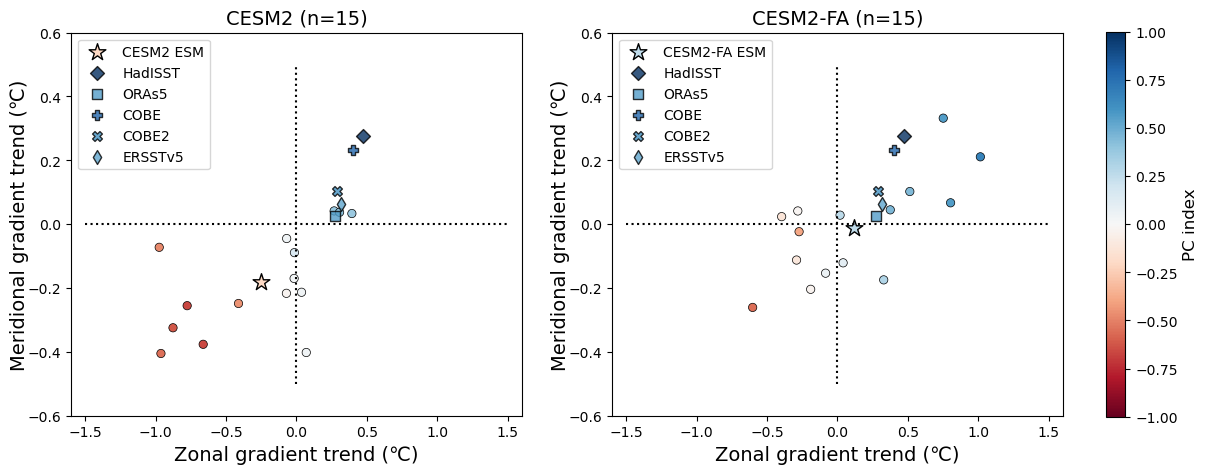

In [14]:
fig, axs = plt.subplots(1,2, figsize=(14,5))#, constrained_layout=True)

markers = ['D','s','P','X','d']
ob_labels = ['HadISST', 'ORAs5' ,'COBE', 'COBE2', 'ERSSTv5']

for ax in axs:
    ax.plot([-1.5,1.5],[0,0],':',c='k')
    ax.plot( [0,0],[-.5,.5],':',c='k')
    ax.set_xlim(-1.6, 1.6) 
    ax.set_ylim(-.6, .6) 
    ax.set_xlabel("Zonal gradient trend (℃)",fontsize=14)
    ax.set_ylabel("Meridional gradient trend (℃)",fontsize=14,labelpad=-1)

ax = axs[0]
ax.set_box_aspect(.85)
expid = 'CESM2 ESM'

im = ax.scatter(lst_cntl_EW, lst_cntl_CE, c=lst_cntl_PCC, cmap='RdBu',vmax=1,vmin=-1, edgecolors='k',linewidths=.5)
ax.scatter(x=EW_cntl,y=CE_cntl, c=PCC_cntl, label=expid, marker='*', cmap='RdBu',vmax=1,vmin=-1, edgecolors='k',s=160, linewidths=1)
for i, prod in enumerate(prods):
    xi = lst_ob_EW[i]; yi = lst_ob_CE[i]; ci = lst_ob_PCC[i]
    ax.scatter(x=xi,y=yi, c=ci,  marker=markers[i], cmap='RdBu', vmax=1, vmin=-1, edgecolors='k', s=50, label = ob_labels[i], 
               alpha=.8)

ax.set_title('CESM2 (n=15)',fontsize=14)
ax.legend(loc='upper left',fontsize=10)

ax = axs[1]
#ax.set_aspect(adjustable='box')# Set the aspect of the plot to be equal
expid = 'CESM2-FA ESM'
im = ax.scatter(lst_fa_EW, lst_fa_CE, c=lst_fa_PCC, cmap='RdBu',vmax=1,vmin=-1, edgecolors='k',linewidths=.5)
ax.scatter(x=EW_fa,y=CE_fa, c=PCC_fa, label=expid, marker='*', cmap='RdBu',vmax=1,vmin=-1, edgecolors='k',s=160, linewidths=1)

for i, prod in enumerate(prods):
    xi = lst_ob_EW[i]; yi = lst_ob_CE[i]; ci = lst_ob_PCC[i]
    ax.scatter(x=xi,y=yi, c=ci,  marker=markers[i], cmap='RdBu', vmax=1, vmin=-1,edgecolors='k',s=50, label = ob_labels[i], 
               alpha=.8)
    #ax.text(x=xi+.1,y=yi-0.02, s=prod,fontsize=13)

cbar = fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('PC index', size=12)
ax.set_title('CESM2-FA (n=15)',fontsize=14)
ax.legend(loc='upper left',fontsize=10)
ax.set_box_aspect(.85)

plt.savefig("fig4_trend_indices_1970-2020.pdf")

## E-W index - focus:

In [15]:
import seaborn as sns
lst_w = []
lst_e = []
EW = []
ds = ds_trend_cntl.mean('member').sel(lon= slice(xE,xW),lat=slice(yS,yN))
dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
ew = -(dsE-dsW).trend.item()
lst_w.append(dsW.trend.item())
lst_e.append(dsE.trend.item())
EW.append(ew)

ds = ds_trend_fa.mean('member').sel(lon= slice(xE,xW),lat=slice(yS,yN))
dsW = ds.sel(lon= slice(xEW_W1,xEW_E1),lat=slice(-yWE,yWE)).mean(['lon','lat'])
dsE = ds.sel(lon= slice(xEW_W2,xEW_E2),lat=slice(-yWE,yWE)).mean(['lon','lat'])
lst_w.append(dsW.trend.item())
lst_e.append(dsE.trend.item())
ew = -(dsE-dsW).trend.item()
EW.append(ew)

df = pd.DataFrame({ 'trend':lst_w+lst_e, 'ocean':['WP','WP','EP','EP',],'Exp.':['CESM2','CESM2-FA','CESM2','CESM2-FA']
                  
                  })
df.to_csv('df_ns5deg_.csv')

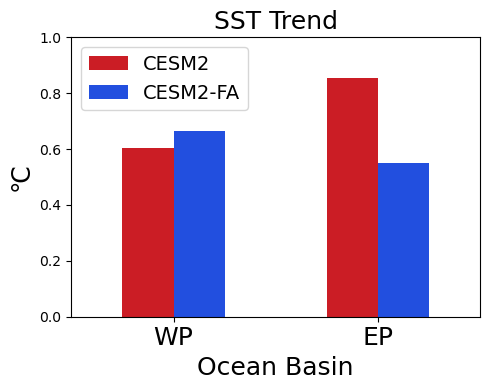

In [42]:
plt.figure(figsize=(5,4))
sns.barplot(data=df, x='ocean',y='trend', hue='Exp.', palette=[sns.color_palette("bright")[3],sns.color_palette("bright")[0]], width=.5)
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('Ocean Basin',fontsize=18)
plt.ylabel('℃',fontsize=18)
plt.ylim(0,1)
plt.xticks([0,1],['WP','EP'],fontsize=18)
plt.title('SST Trend',fontsize=18)
plt.tight_layout()
plt.savefig("fig3e_wpep_trend.pdf",transparent=True)

In [17]:
df

,trend,ocean,Exp.
0,0.603530,WP,CESM2
1,0.665200,WP,CESM2-FA
2,0.854356,EP,CESM2
3,0.549573,EP,CESM2-FA


WP relative chanve = 10.22, EP relative change = -35.67
10.2 percent, -35.7 percent


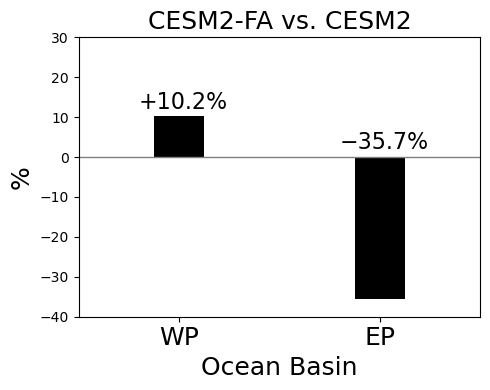

In [41]:
wp_per = (df.trend[1]-df.trend[0])/df.trend[0]*100
ep_per = (df.trend[3]-df.trend[2])/df.trend[2]*100
print('WP relative chanve = %.2f, EP relative change = %.2f'%(wp_per, ep_per))
print('%.1f percent, %.1f percent'%(wp_per, ep_per))

plt.figure(figsize=(5,4))
df_ = pd.DataFrame({'ocean':['WP','EP'],'trend':[wp_per, ep_per]})
ax = sns.barplot(data=df_, x='ocean',y='trend', color='k', width=.25)
ax.set_xlabel('Ocean Basin',fontsize=18)
ax.set_ylabel('%',fontsize=18)
ax.set_ylim([-40,30])
ax.set_xticks([0,1])
ax.set_xticklabels(['WP','EP'],fontsize=18)
ax.set_title('CESM2-FA vs. CESM2',fontsize=18)
ax.axhline(0, color='gray', linestyle='-', linewidth=1)
ax.text(x=0-.2, y=11+1, s='+10.2%', fontsize=16)
ax.text(x=1-.2, y=0+2, s='−35.7%', fontsize=16)
plt.tight_layout()
plt.savefig("fig3g_wpep_trend_precent.pdf",transparent=True)